# Linear dynamical systems

In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import seaborn as sns
from functools import partial
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib.lines import Line2D

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
color = "#5A5A5A"

In [4]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (7.2, 4.0)

sns.set_palette("colorblind")

In [5]:
jnp.exp(3) / 20

Array(1.0042769, dtype=float32, weak_type=True)

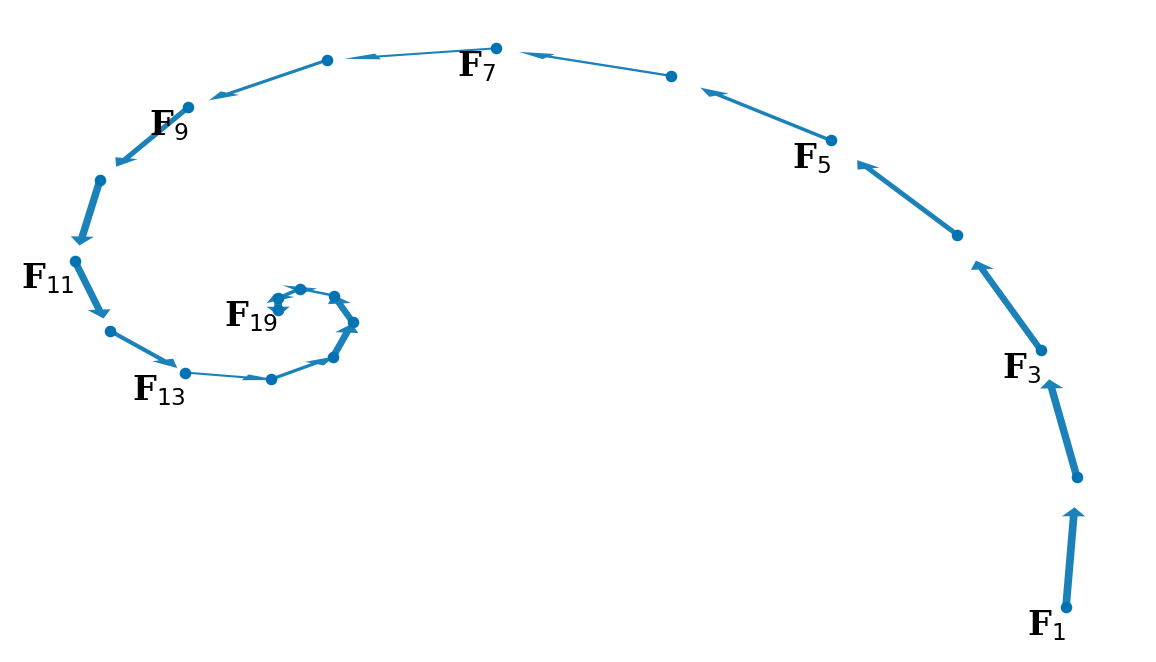

In [6]:
def f(x, t):
    x, y = x
    ẋ = -(x + y)
    ẏ = 6 * x - y
    return ẋ, ẏ
time = np.linspace(0, np.exp(3), 20)
time = np.exp(0.08163265) ** time
X = odeint(f, np.array([1.0, -1.5]), t=time)
plt.scatter(*X.T, s=10)

for i, (init, end) in enumerate(zip(X[:-1], X[1:])):
    Δx = end - init
    plt.arrow(*init, *Δx * 0.7, head_width=0.03, edgecolor="None", width=0.01, alpha=0.9)
    if i in [0, 2, 4, 6,8, 10, 12, 18]:
        plt.text(*init, r"F$_{"f"{i+1}""}$", horizontalalignment="right",
                 verticalalignment="top",
                 fontsize=12,
                 family="serif",
                 weight="bold"
                )
# plt.grid(alpha=0.3)
plt.axis("off")
plt.savefig("./discrete-dynamical-system.png", dpi=200, bbox_inches="tight")

# Linear dynamical system

In [7]:
c0, c1 = sns.color_palette()[:2]

c0 = "#5A5A5A"
c1 = "#DC143C"

custom_lines = [
    Line2D([0], [0], color=c0, lw=2),
    Line2D([0], [0], color=c1, lw=2)
]

In [9]:
T = 5
n_steps = 1000
dt = T / n_steps

F = np.array([
    [1 - dt, -dt],
    [6 * dt, 1 - dt]
])

F = jnp.array([
    [1 - dt + (dt**2) / 2, -dt + (dt**2)],
    [6 * dt - 6 * (dt**2), 1 - dt + (dt**2) / 2]
])


H = jnp.eye(2)
R = np.eye(2) * 0.001
Q = np.eye(2) * 0.0

In [10]:
def step(theta, key, F, H, dt):
    key_noise, key_dynamics = jax.random.split(key)
    noise = jnp.sqrt(R) @ jax.random.normal(key_noise, (H.shape[0],))
    latent_noise = jnp.sqrt(Q) @ jax.random.normal(key_dynamics, (F.shape[0],))
    theta_new = F @ theta + latent_noise * jnp.sqrt(dt)
    signal = H @ theta_new
    measurement = signal + noise
    return theta_new, (signal, measurement)


def simulate(key, latent_init, T, n_steps):
    dt = T / n_steps
    keys = jax.random.split(key, n_steps)
    F = jnp.array([
        [1 - dt + (dt**2) / 2, -dt + (dt**2)],
        [6 * dt - 6 * (dt**2), 1 - dt + (dt**2) / 2]
    ])

    pstep = partial(step, F=F, H=H, dt=dt)
    _, (signal, measurement) = jax.lax.scan(pstep, theta_init, keys)
    return {
        "signal": signal,
        "measurement": measurement
    }

In [11]:
theta_init = jnp.array([1.0, -1.5])
key = jax.random.PRNGKey(314)

T = 5
n_steps = 1000
res = simulate(key, theta_init, T, n_steps)

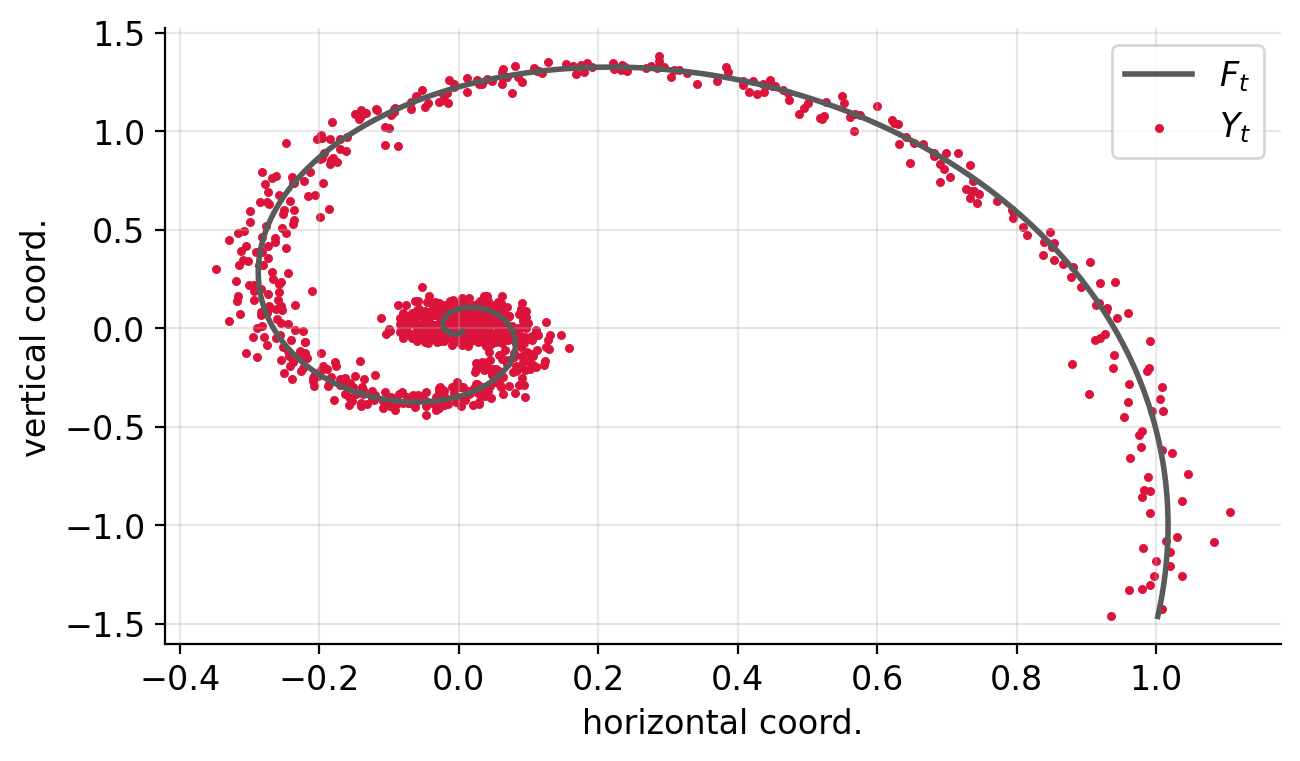

In [12]:
plt.plot(*res["signal"].T, color=c0, linewidth=2, label="$F_t$")
plt.scatter(*res["measurement"].T, c=c1, alpha=1.0, zorder=0, s=5, label="$Y_t$")
plt.legend()
plt.grid(alpha=0.3)
plt.xlabel("horizontal coord.")
plt.ylabel("vertical coord.")
plt.savefig("./discrete-dynamical-system-with-obs.png", dpi=200, bbox_inches="tight")

### Multiple simulations

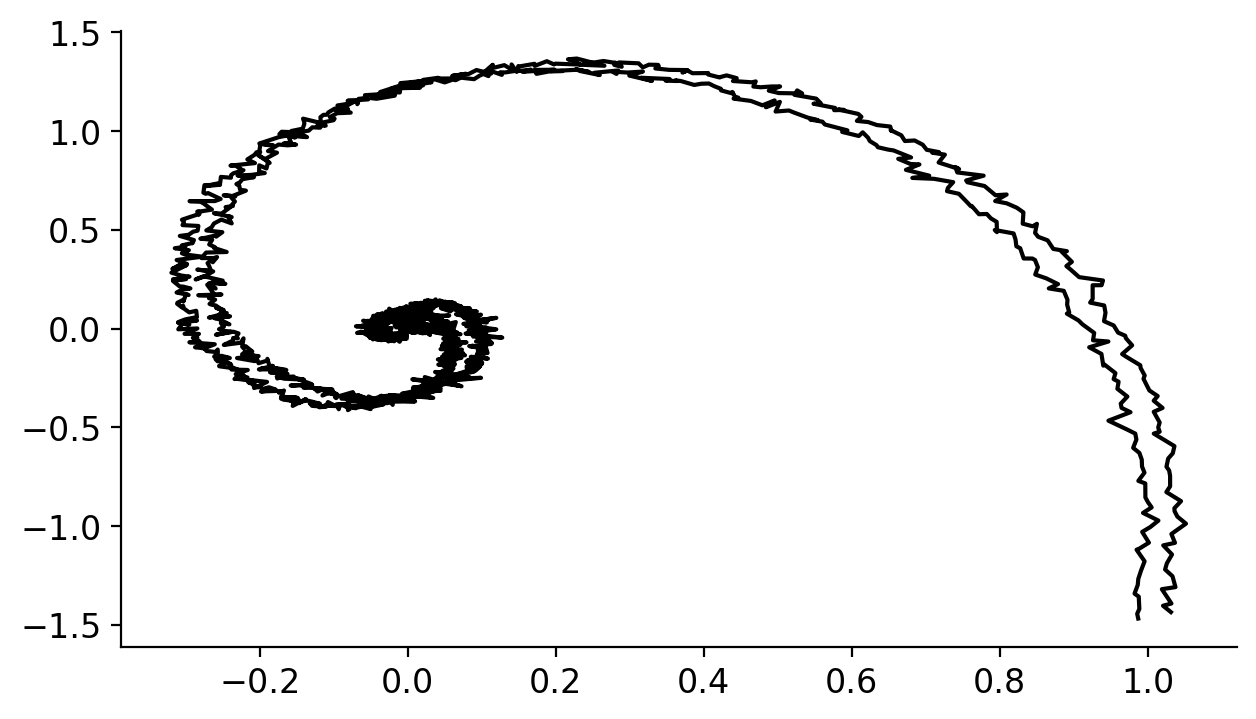

In [43]:
vmin = np.quantile(res["measurement"], 0.25, axis=0)
vmax = np.quantile(res["measurement"], 0.75, axis=0)

plt.plot(vmin[:, 0], vmin[:, 1], c="black")
plt.plot(vmax[:, 0], vmax[:, 1], c="black")

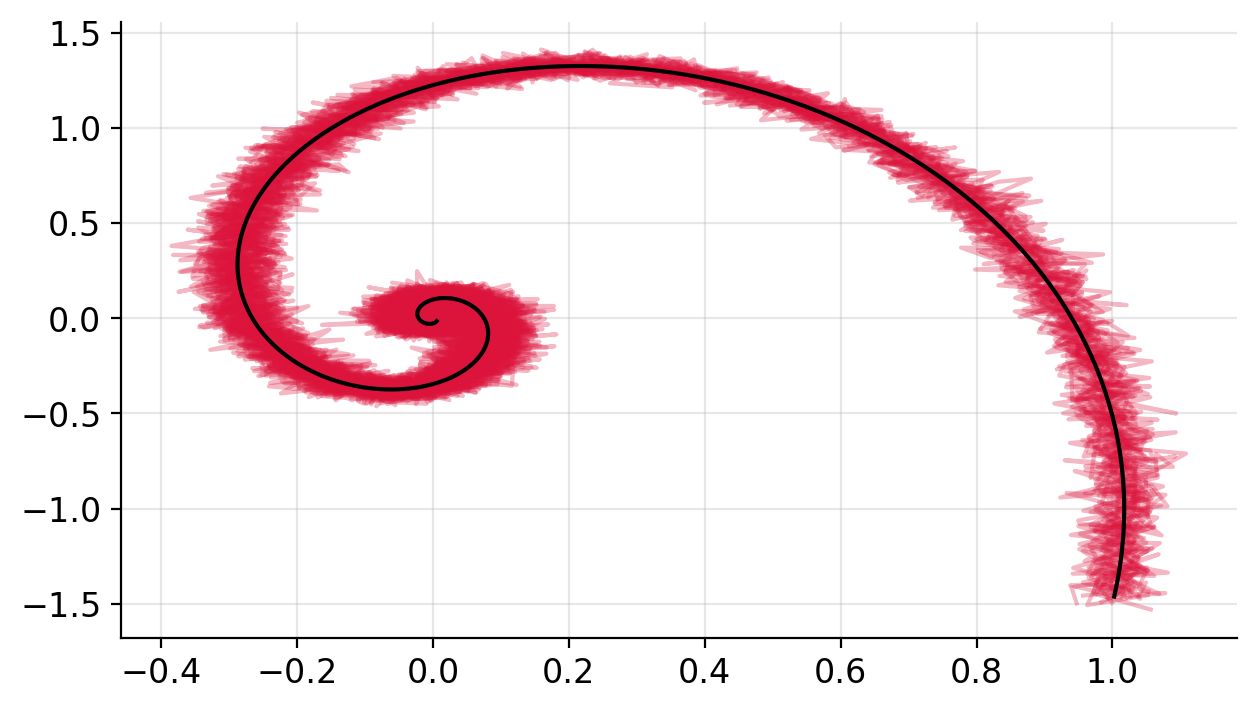

In [13]:
n_sims = 20
key_sims = jax.random.split(key, n_sims)
vsim = jax.vmap(simulate, in_axes=(0, None, None, None))
res = vsim(key_sims, theta_init, T, n_steps)

for sim in res["measurement"]:
    plt.plot(*sim.T, c=c1, alpha=0.3)
plt.plot(*res["signal"][0].T, c="black")
plt.grid(alpha=0.3)

## The error variance-covariance (EVC) matrix

In [135]:
def evc_step(sigma, step, F, H, Q, R):
    """
    Compute the predicted and updated
    error variance covariance matrix (EVC)
    as well as the variance of innovations.
    We assume
        1. fixed projection matrix H,
        2. fixed transition matrix P,
        3. fixed dynamics covariance Q, and
        4. fixed measurement covariance R.
    """
    sigma_pred = F @ sigma @ F.T + Q
    var_innov = H @ sigma_pred @ H.T + R
    K = jnp.linalg.solve(var_innov, H.T @ sigma_pred).T
    sigma_update = sigma_pred - K @ var_innov @ K.T

    out = {
        "sigma_pred": sigma_pred,
        "var_innov": var_innov,
        "sigma": sigma_update,
    }
    return sigma_update, out

def Mfunc(Sigma_pred, var_innov, F, H):
    M = F  - F @ Sigma_pred @ H.T @ var_innov @ H
    return M

In [136]:
Sigma_init = jnp.eye(2)
steps = jnp.arange(n_steps)
stepfn = partial(evc_step, F=F, H=H, Q=Q, R=R)
_, hist_evc = jax.lax.scan(stepfn, Sigma_init, steps)

In [138]:
hist_M = jax.tree.map(partial(Mfunc, F=F, H=H), hist_evc["sigma_pred"], hist_evc["var_innov"])

## Building fundamental covariance matrix

In [139]:
hist_sigma_pred = hist_evc["sigma_pred"]
hist_sigma_update = hist_evc["sigma"]
hist_innov = hist_evc["var_innov"]

In [140]:
def step_fwd(cov, t):
    cov = cov.at[t].set(F @ cov[t-1])
    cov = cov.at[t,t].set(hist_sigma_pred[t])
    return cov, None

In [167]:
# Initialise fundamental covariance
covariance_fundamental = jnp.zeros((n_steps, n_steps, 2, 2))
covariance_fundamental = covariance_fundamental.at[0,0].set(hist_sigma_pred[0])

# fwd pass
steps = jnp.arange(n_steps)
covariance_fundamental, _ = jax.lax.scan(step_fwd, covariance_fundamental, steps)

# backward pass


In [168]:
covariance_fundamental[-2, -2:]

Array([[[ 1.49675133e-10, -1.01346556e-10],
        [-1.01346445e-10,  1.04825992e-09]],

       [[ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00]]], dtype=float32)

In [225]:
def step_backward(A, t):
    # Multiply existing terms by M matrix
    A = jnp.einsum("ji,sjk->sik", hist_M[t], A)
    # update current A element
    A = A.at[t+1].set(hist_M[t].T @ H.T)

    cov_fundamental_part = jnp.einsum("ij,sjk->sik", hist_sigma_pred[t], A)
    return A, cov_fundamental_part

In [272]:
# Initialise A marix
A_matrices = jnp.zeros((n_steps, 2, 2))
A_matrices = A_matrices.at[n_steps - 1].set(hist_M[-2].T @ H.T)

steps_backward = np.arange(n_steps-2, -1, -1)

In [273]:
A_final, cov_fundamental_upper = jax.lax.scan(step_backward, A_matrices, steps_backward)

In [266]:
jnp.einsum("smij->msij", cov_fundamental_upper)[-1, :, 0, 0]

Array([ 1.48708879e-10,  1.49432827e-10,  1.49626506e-10,  1.49795898e-10,
        1.49940740e-10,  1.50060769e-10,  1.50155721e-10,  1.50225318e-10,
        1.50269297e-10,  1.50287394e-10,  1.50279345e-10,  1.50244900e-10,
        1.50183824e-10,  1.50095852e-10,  1.49980722e-10,  1.49838197e-10,
        1.49668028e-10,  1.49469950e-10,  1.49243756e-10,  1.48989168e-10,
        1.48705978e-10,  1.48393936e-10,  1.48052848e-10,  1.47682436e-10,
        1.47282506e-10,  1.46852822e-10,  1.46393175e-10,  1.45903331e-10,
        1.45383094e-10,  1.44832257e-10,  1.44250598e-10,  1.43637935e-10,
        1.42994033e-10,  1.42318726e-10,  1.41611819e-10,  1.40873091e-10,
        1.40102402e-10,  1.39299586e-10,  1.38464379e-10,  1.37596684e-10,
        1.36696279e-10,  1.35763040e-10,  1.34796799e-10,  1.33797348e-10,
        1.32764605e-10,  1.31698374e-10,  1.30598546e-10,  1.29464953e-10,
        1.28297442e-10,  1.27095917e-10,  1.25860253e-10,  1.24590310e-10,
        1.23285979e-10,  

In [262]:
cov_fundamental_upper.shape

(1000, 1000, 2, 2)

In [260]:
cov_fundamental_upper[-1, :, 0, 0]

Array([ 0.00000000e+00,  1.69112626e-02,  1.70628168e-02,  1.72099471e-02,
        1.73526518e-02,  1.74909513e-02,  1.76248681e-02,  1.77544132e-02,
        1.78796146e-02,  1.80004872e-02,  1.81170553e-02,  1.82293355e-02,
        1.83373578e-02,  1.84411425e-02,  1.85407121e-02,  1.86360907e-02,
        1.87273081e-02,  1.88143775e-02,  1.88973360e-02,  1.89762060e-02,
        1.90510098e-02,  1.91217773e-02,  1.91885345e-02,  1.92513112e-02,
        1.93101373e-02,  1.93650387e-02,  1.94160454e-02,  1.94631834e-02,
        1.95064843e-02,  1.95459817e-02,  1.95816997e-02,  1.96136758e-02,
        1.96419377e-02,  1.96665153e-02,  1.96874421e-02,  1.97047517e-02,
        1.97184756e-02,  1.97286457e-02,  1.97352953e-02,  1.97384600e-02,
        1.97381638e-02,  1.97344590e-02,  1.97273642e-02,  1.97169203e-02,
        1.97031591e-02,  1.96861178e-02,  1.96658242e-02,  1.96423251e-02,
        1.96156502e-02,  1.95858348e-02,  1.95529182e-02,  1.95169337e-02,
        1.94779169e-02,  

In [223]:
t = 997

# Multiple A matrices
A_matrices = jnp.einsum("ji,sjk->sik", hist_M[t], A_matrices)

A_matrices = A_matrices.at[t+1].set(hist_M[t].T @ H.T)

In [215]:
A_matrices

Array([[[ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       ...,

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.9950125 ,  0.02985   ],
        [-0.004975  ,  0.9950125 ]],

       [[ 0.99007463,  0.02475094],
        [ 0.02475094,  0.9909409 ]]], dtype=float32)

In [220]:
jnp.einsum("ij,sjk->sik", hist_sigma_pred[t], A_matrices)

Array([[[ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00]],

       ...,

       [[ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00]],

       [[ 1.49893653e-10, -9.65726873e-11],
        [-1.06351324e-10,  1.05641251e-09]],

       [[ 1.46133300e-10, -9.69247321e-11],
        [-7.41990080e-11,  1.05259512e-09]]], dtype=float32)

In [219]:
A_matrices.shape

(1000, 2, 2)

In [217]:
hist_sigma_pred[t].shape

(2, 2)